In [ ]:
# Installs packages and clones to Colab
!pip install import-ipynb # to import functions from other ipynb files
!git clone https://github.com/peepkolberg/CNS-EOG-classifier.git
%cd CNS-EOG-classifier/

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=db79d1ec32d3a9c687f0e2aca1d48f9c53370ea64d64da7b49714b4f866a9dce
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
Cloning into 'CNS-EOG-classifier'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 89 (delta 23), reused 35 (delta 13), pack-reused 43
Unpacking objects: 100% (89/89), done.
/content/CNS-EOG-classifier


importing Jupyter notebook from preprocess.ipynb
     |████████████████████████████████| 1.1 MB 4.3 MB/s 
Looks good! All experiments contain all classes.
Total 16 datasets from 16 experiments.


Participant 1 experiment 0 data sample:

     time_sec  time_microsec  ...  signal_horizontal_nk  signal_vertical_nk
0  1237450899         488784  ...           2471.462613        -8734.576266
1  1237450899         499103  ...           1317.719686        -8526.747135
2  1237450899         499143  ...           1719.976759        -9484.918004
3  1237450899         519098  ...           2145.233832        -7695.088873
4  1237450899         519137  ...           2701.490905        -6113.259742

[5 rows x 8 columns]

Columns and their data types: 
time_sec                  int32
time_microsec             int32
time_full               float64
signal_horizontal         int32
signal_vertical           int32
class                     int32
signal_horizontal_nk    float64
signal_vertical_nk      float

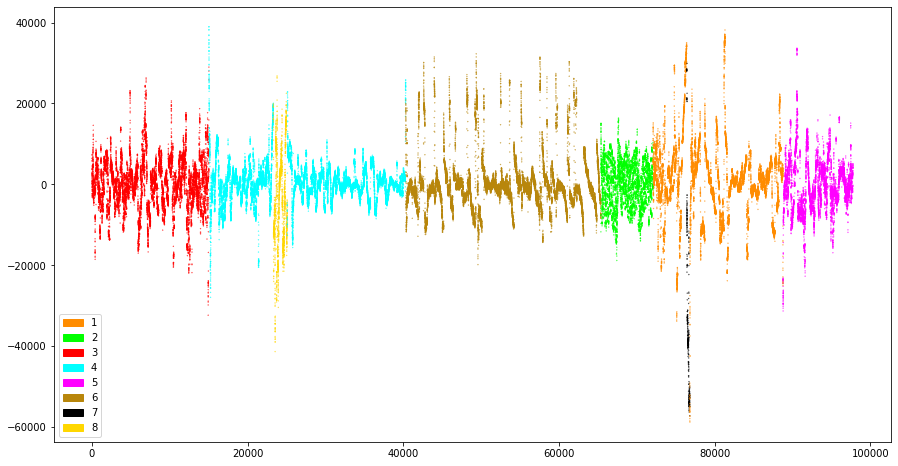

In [ ]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import preprocess    #import the functions to read .mat files into DataFrames

In [ ]:
# Various data preparing functions. 

def safely_remove_distraction_classes(datasets_dict):
    """
    Removes the distraction classes (labels 7 and 8) from the datasets without concatenating the surrounding class.
    Since each distraction is in the middle of another class, this function separates the surrounding class into two parts.
    The parts will be denoted by appending .1 or .2 to the surrounding class labels that are before and after the distraction class, respectively.
    """
    for participant, experiments in datasets_dict.items():
        for experiment, df in experiments.items():
            for dis_label in (7, 8):
                dis_df_idx = df[df['class'] == dis_label].index
    
                dis_start_idx = dis_df_idx[0]
                dis_end_idx = dis_df_idx[-1]
                #print(f"participant {participant} experiment {experiment} label {dis_label} start index {dis_start_idx} end index {dis_end_idx}")
        
                surrounding_class_label = df['class'][dis_start_idx - 1]
            
                before_dis_class = df[ (df['class'] == surrounding_class_label) & (df.index < dis_start_idx) ]
                after_dis_class = df[ (df['class'] == surrounding_class_label) & (df.index > dis_end_idx) ]
                
                df.loc[before_dis_class.index[0] : dis_start_idx, 'class'] = surrounding_class_label + 0.1
                df.loc[after_dis_class.index[0] : after_dis_class.index[-1]+1, 'class'] = surrounding_class_label + 0.2
                
                df.drop(index=range(dis_start_idx, dis_end_idx+1), inplace=True)
                #print(df['class'].unique())

def data_split(df, data_columns, chunk_size, window_step):
  """
  Input: DataFrame, data column names, chunk size and window step
  Outputs: NumPy arrays of data (X) and labels (y)

  Splits time-series data into equal-sized chunks.
  Also removes the .1 and .2 from previously separated labels.
  """

  X = []
  y = []

  for label in df['class'].unique():
    class_df = df[df['class'] == label]

    signals = np.asarray(class_df[data_columns])
    
    for i in range(0, len(signals), window_step): 
      chunk = signals[i : i + chunk_size]

      if len(chunk) != chunk_size:
        break

      X.append(chunk)
      y.append(int(label))

  return np.asarray(X), np.asarray(y) - 1    # Subtracting 1 from labels because keras tools expect numerical labels to start from 0

def split_datasets(datasets_dict, data_columns, chunk_size, sliding_window_step = -1):
  """ 
  Splits each dataset into chunks. If sliding_window_step argument is given, applies sliding window sampling.
  Also separates signal data (X) and labels (y).
  """

  # If step is not given, move the window by the entire length of the window.
  if sliding_window_step == -1:
    sliding_window_step = chunk_size

  for participant, exps in datasets_dict.items():
    for experiment, data in exps.items():
      #print(f"starting participant {participant} experiment {experiment}")
      X, y = data_split(data, data_columns, chunk_size, sliding_window_step)
      #print(f"got total {len(X)} chunks, {len(y)} labels")
      datasets_dict[participant][experiment] = {'X': X, 'y': y} # <-- To also rename labels to their corresponding words, use rename_labels(y) instead of y

def one_hot_encode_labels(datasets_dict):
  for p, exps in datasets_dict.items():
    for e, data in exps.items():
      data['y'] = to_categorical(data['y'])

def normalize_per_dataset(datasets_dict, data_columns):
  for p, exps in datasets_dict.items():
    for e, data in exps.items():
      for col_name in data_columns:
        initial = np.asarray(data[col_name])
        max, min = np.max(initial), np.min(initial)
        normalized = 2 * ( (initial-min) / (max-min) ) - 1 # normalize between -1 and 1
        data[col_name] = normalized

def print_data_dimensions(datasets_dict):
  total_chunks = 0
  total_labels = 0
  for participant, experiments in datasets_dict.items():
    for experiment, data in experiments.items():
      print(f"participant:{participant}   experiment:{experiment}")
      print(f"signals shape:{data['X'].shape}")
      print(f" labels shape:{data['y'].shape}")
      total_chunks += data['X'].shape[0]
      total_labels += data['y'].shape[0]
  print(f"\nTotal {total_chunks} chunks and {total_labels} labels.   <-- Check that they are equal!")

def concat_datasets(datasets_dict, participants):
  """ Input: datasets dictionary (that has split data and labels for each experiment) """
  X = []
  y = []

  for p in participants:
    for e in (0, 1):
      X.append(datasets_dict[p][e]['X'])
      y.append(datasets_dict[p][e]['y'])

  X = np.concatenate(X)
  y = np.concatenate(y)
  
  return X, y

def labels_to_words(numerical_labels):
    """ 
    For converting labels from numbers (0-7) to their word representations ('null', 'read', etc.)
    Input: numerical labels as a 1D array. 
    """
    replacements = {0: 'null', 
                    1: 'read', 
                    2: 'browse', 
                    3: 'write', 
                    4: 'video', 
                    5: 'copy', 
                    6: 'disspeak', 
                    7: 'disphone'}
    return np.asarray([replacements[old_label] for old_label in numerical_labels])

def plot_conf_matrix(true_labels, predictions):
  fig = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_labels, predictions)).plot(cmap=plt.cm.Blues)
  plt.title(f"Participant {testing_participant} confusion matrix")
  ax = plt.gca()
  plt.xticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  plt.yticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  ax.xaxis.set_ticks_position('top')
  ax.xaxis.set_label_position('top')
  plt.show()

def grid_search(X_train, y_train, X_test, y_test):
  model = KerasClassifier(build_fn=compile_model, verbose=0)

  batch_size = [10, 20, 30, 40, 60, 80, 100]
  epochs = [10, 20, 30, 50, 70, 100]
  optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
  cnn_activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
  dense_activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
  dropout_rate = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

  param_grid = dict(batch_size=batch_size,
                    epochs=epochs, 
                    optimizer=optimizer, 
                    cnn_activation=cnn_activation, 
                    dense_activation=dense_activation, 
                    dropout_rate=dropout_rate
                    )
  
  X = np.concatenate([X_train, X_test])
  y = np.concatenate([y_train, y_test])
  test_fold = np.concatenate([np.repeat(-1, len(y_train)), np.repeat(0, len(y_test))])
  
  grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=PredefinedSplit(test_fold=test_fold))
  grid_result = grid.fit(X, y)

  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



# UNUSED FUNCTIONS
def get_global_max_and_min(datasets_dict, col_name):
  datas = []

  # concat all columns of that name
  for p, exps in datasets_dict.items():
    for e, data in exps.items():
      datas.append(data[col_name])

  datas = np.asarray(datas)
  data = np.concatenate(datas)

  return np.max(data), np.min(data)

def get_delta(column_data):
  initial = np.append(column_data, 0)
  helper = np.concatenate(([column_data[0]], column_data))
  delta = initial - helper
  delta = np.absolute(delta)
  return delta[:-1]

def add_signal_deltas(datasets_dict):
  for p, exps in datasets_dict.items():
    for e, data in exps.items():
      data['signal_horizontal_delta'] = get_delta(data['signal_horizontal'])
      data['signal_vertical_delta'] = get_delta(data['signal_vertical'])


In [ ]:
# Read files into dataframes (see function description in preprocess.ipynb for details)
datasets_dict = preprocess.read_all_files()

# Remove distraction classes
# The classes that surround the distraction class will be split into two parts by appending .1 or .2 to the label. 
safely_remove_distraction_classes(datasets_dict)

# Add columns for signal deltas - broken
#add_signal_deltas(datasets_dict)

# Define which columns contain the desired signal datas
data_columns = [
                'signal_horizontal', 
                'signal_vertical', 
                'signal_horizontal_nk', 
                'signal_vertical_nk'
                ]

# Normalize data
normalize_per_dataset(datasets_dict, data_columns)

# Split each class in dataset into chunks. Can be used for sliding window sampling (sliding_window_step argument must be given).
#
# Also subtracts 1 from all labels so they start from 0.
split_datasets(datasets_dict, data_columns, chunk_size = 625, sliding_window_step = 64)

# One-hot encode labels
one_hot_encode_labels(datasets_dict)

# Print the final dimensions of each dataset
print_data_dimensions(datasets_dict)

participant:1   experiment:0
signals shape:(1418, 625, 4)
 labels shape:(1418, 6)
participant:1   experiment:1
signals shape:(2330, 625, 4)
 labels shape:(2330, 6)
participant:2   experiment:0
signals shape:(3318, 625, 4)
 labels shape:(3318, 6)
participant:2   experiment:1
signals shape:(1693, 625, 4)
 labels shape:(1693, 6)
participant:3   experiment:0
signals shape:(3259, 625, 4)
 labels shape:(3259, 6)
participant:3   experiment:1
signals shape:(3362, 625, 4)
 labels shape:(3362, 6)
participant:4   experiment:0
signals shape:(2969, 625, 4)
 labels shape:(2969, 6)
participant:4   experiment:1
signals shape:(2915, 625, 4)
 labels shape:(2915, 6)
participant:5   experiment:0
signals shape:(3115, 625, 4)
 labels shape:(3115, 6)
participant:5   experiment:1
signals shape:(2658, 625, 4)
 labels shape:(2658, 6)
participant:6   experiment:0
signals shape:(3169, 625, 4)
 labels shape:(3169, 6)
participant:6   experiment:1
signals shape:(2807, 625, 4)
 labels shape:(2807, 6)
participant:7   


Starting testing participant 1

Training data shape: (40346, 625, 4)   labels shape: (40346, 6)
Testing data shape:  (3748, 625, 4)    labels shape: (3748, 6)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_1 (Laye  (None, 625, 4)           1250      
 rNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, 625, 4)            52        
                                                                 
 batch_normalization_3 (Batc  (None, 625, 4)           16        
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 625, 8)            168       
                                                                 
 batch_normalization_4 (B

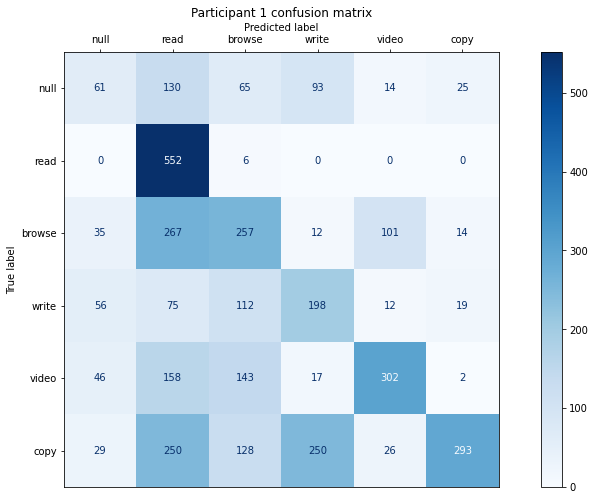


Starting testing participant 2

Training data shape: (39083, 625, 4)   labels shape: (39083, 6)
Testing data shape:  (5011, 625, 4)    labels shape: (5011, 6)

Epoch 1/16
1955/1955 [==============================] - 23s 11ms/step - loss: 1.5724 - accuracy: 0.3526 - val_loss: 1.5508 - val_accuracy: 0.3760
Epoch 2/16
1955/1955 [==============================] - 21s 11ms/step - loss: 1.3683 - accuracy: 0.4581 - val_loss: 1.9696 - val_accuracy: 0.3083
Epoch 3/16
1955/1955 [==============================] - 21s 11ms/step - loss: 1.2404 - accuracy: 0.5141 - val_loss: 1.6668 - val_accuracy: 0.3746
Epoch 4/16
1955/1955 [==============================] - 21s 11ms/step - loss: 1.1669 - accuracy: 0.5470 - val_loss: 1.5261 - val_accuracy: 0.4077
Epoch 5/16
1955/1955 [==============================] - 21s 11ms/step - loss: 1.1251 - accuracy: 0.5674 - val_loss: 1.8173 - val_accuracy: 0.3764
Epoch 6/16
1955/1955 [==============================] - 21s 11ms/step - loss: 1.0999 - accuracy: 0.5754 - val

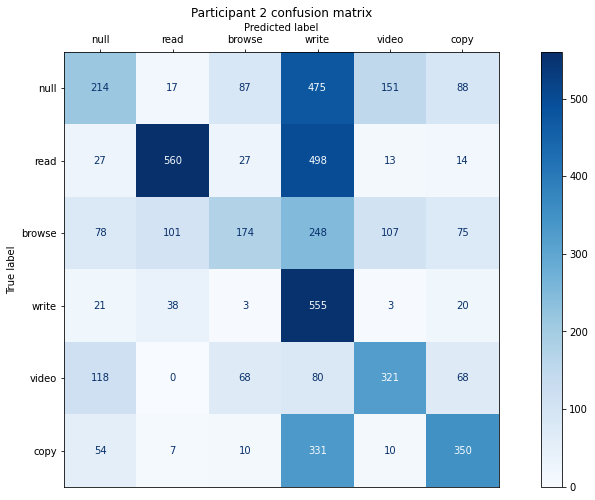


Starting testing participant 3

Training data shape: (37473, 625, 4)   labels shape: (37473, 6)
Testing data shape:  (6621, 625, 4)    labels shape: (6621, 6)

Epoch 1/16
1874/1874 [==============================] - 22s 11ms/step - loss: 1.5287 - accuracy: 0.3843 - val_loss: 1.3814 - val_accuracy: 0.4153
Epoch 2/16
1874/1874 [==============================] - 21s 11ms/step - loss: 1.3384 - accuracy: 0.4730 - val_loss: 1.2969 - val_accuracy: 0.4306
Epoch 3/16
1874/1874 [==============================] - 21s 11ms/step - loss: 1.2501 - accuracy: 0.5157 - val_loss: 1.3663 - val_accuracy: 0.4311
Epoch 4/16
1874/1874 [==============================] - 21s 11ms/step - loss: 1.1828 - accuracy: 0.5460 - val_loss: 1.1397 - val_accuracy: 0.5534
Epoch 5/16
1874/1874 [==============================] - 21s 11ms/step - loss: 1.1267 - accuracy: 0.5724 - val_loss: 1.4514 - val_accuracy: 0.4596
Epoch 6/16
1874/1874 [==============================] - 21s 11ms/step - loss: 1.0873 - accuracy: 0.5876 - val

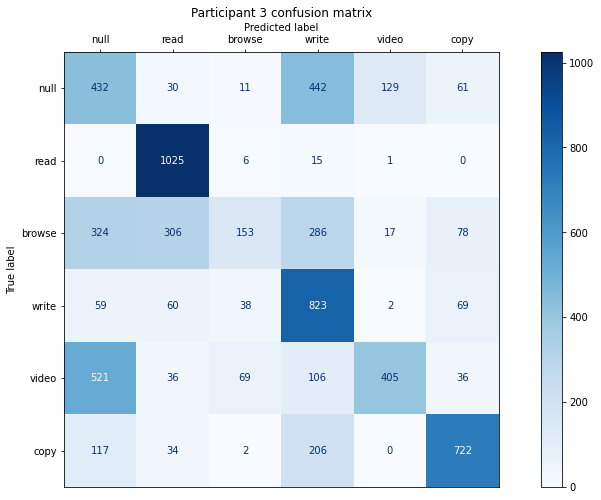


Starting testing participant 4

Training data shape: (38210, 625, 4)   labels shape: (38210, 6)
Testing data shape:  (5884, 625, 4)    labels shape: (5884, 6)

Epoch 1/16
1911/1911 [==============================] - 23s 11ms/step - loss: 1.5674 - accuracy: 0.3525 - val_loss: 1.8363 - val_accuracy: 0.2989
Epoch 2/16
1911/1911 [==============================] - 21s 11ms/step - loss: 1.4105 - accuracy: 0.4480 - val_loss: 1.9783 - val_accuracy: 0.3289
Epoch 3/16
1911/1911 [==============================] - 21s 11ms/step - loss: 1.3447 - accuracy: 0.4816 - val_loss: 2.1171 - val_accuracy: 0.3001
Epoch 4/16
1911/1911 [==============================] - 22s 11ms/step - loss: 1.2869 - accuracy: 0.5031 - val_loss: 2.0598 - val_accuracy: 0.3163
Epoch 5/16
1911/1911 [==============================] - 21s 11ms/step - loss: 1.2285 - accuracy: 0.5287 - val_loss: 2.1058 - val_accuracy: 0.3241
Epoch 6/16
1911/1911 [==============================] - 21s 11ms/step - loss: 1.1839 - accuracy: 0.5516 - val

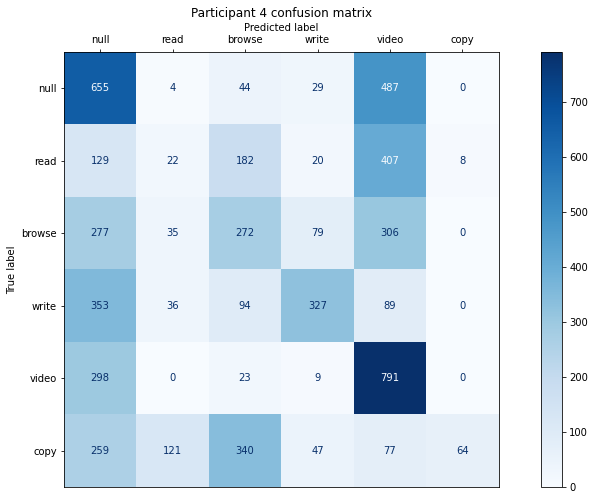


Starting testing participant 5

Training data shape: (38321, 625, 4)   labels shape: (38321, 6)
Testing data shape:  (5773, 625, 4)    labels shape: (5773, 6)

Epoch 1/16
1917/1917 [==============================] - 23s 11ms/step - loss: 1.5807 - accuracy: 0.3400 - val_loss: 1.7725 - val_accuracy: 0.2848
Epoch 2/16
1917/1917 [==============================] - 21s 11ms/step - loss: 1.3640 - accuracy: 0.4495 - val_loss: 1.3425 - val_accuracy: 0.4608
Epoch 3/16
1917/1917 [==============================] - 21s 11ms/step - loss: 1.2562 - accuracy: 0.5102 - val_loss: 1.5229 - val_accuracy: 0.4448
Epoch 4/16
1917/1917 [==============================] - 21s 11ms/step - loss: 1.1911 - accuracy: 0.5463 - val_loss: 1.3758 - val_accuracy: 0.4765
Epoch 5/16
1917/1917 [==============================] - 21s 11ms/step - loss: 1.1443 - accuracy: 0.5707 - val_loss: 1.5478 - val_accuracy: 0.4471
Epoch 6/16
1917/1917 [==============================] - 21s 11ms/step - loss: 1.1118 - accuracy: 0.5824 - val

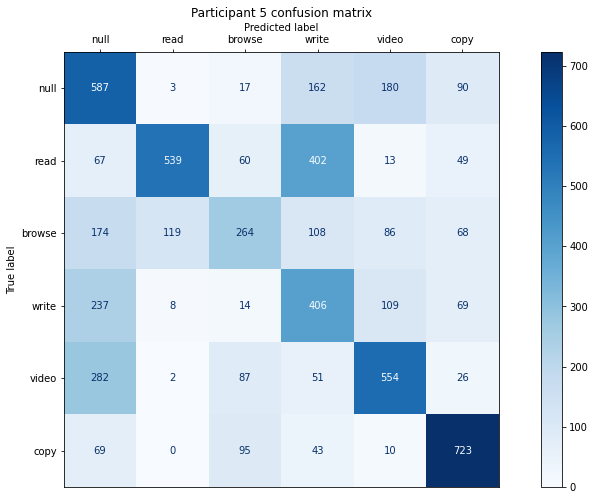


Starting testing participant 6

Training data shape: (38118, 625, 4)   labels shape: (38118, 6)
Testing data shape:  (5976, 625, 4)    labels shape: (5976, 6)

Epoch 1/16
1906/1906 [==============================] - 23s 11ms/step - loss: 1.5921 - accuracy: 0.3455 - val_loss: 1.4777 - val_accuracy: 0.4324
Epoch 2/16
1906/1906 [==============================] - 21s 11ms/step - loss: 1.4106 - accuracy: 0.4436 - val_loss: 1.5572 - val_accuracy: 0.3971
Epoch 3/16
1906/1906 [==============================] - 22s 11ms/step - loss: 1.2891 - accuracy: 0.4956 - val_loss: 1.3642 - val_accuracy: 0.4705
Epoch 4/16
1906/1906 [==============================] - 21s 11ms/step - loss: 1.2240 - accuracy: 0.5258 - val_loss: 1.2638 - val_accuracy: 0.4756
Epoch 5/16
1906/1906 [==============================] - 21s 11ms/step - loss: 1.1766 - accuracy: 0.5451 - val_loss: 1.1255 - val_accuracy: 0.5566
Epoch 6/16
1906/1906 [==============================] - 22s 11ms/step - loss: 1.1356 - accuracy: 0.5621 - val

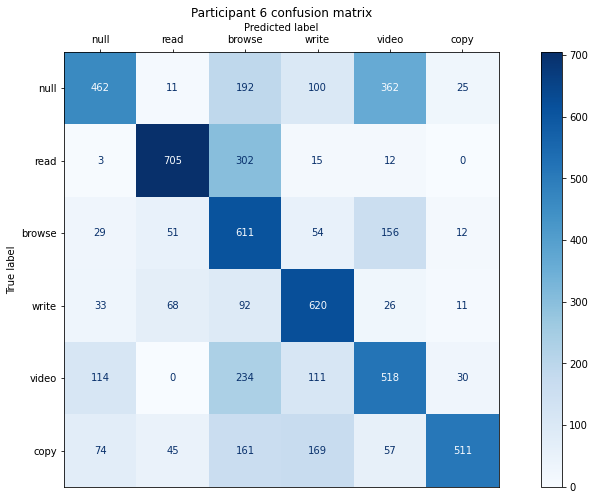


Starting testing participant 7

Training data shape: (38818, 625, 4)   labels shape: (38818, 6)
Testing data shape:  (5276, 625, 4)    labels shape: (5276, 6)

Epoch 1/16
1941/1941 [==============================] - 24s 11ms/step - loss: 1.5559 - accuracy: 0.3537 - val_loss: 1.6598 - val_accuracy: 0.3378
Epoch 2/16
1941/1941 [==============================] - 22s 11ms/step - loss: 1.3685 - accuracy: 0.4491 - val_loss: 1.4223 - val_accuracy: 0.4437
Epoch 3/16
1941/1941 [==============================] - 22s 11ms/step - loss: 1.2692 - accuracy: 0.4939 - val_loss: 1.3500 - val_accuracy: 0.4873
Epoch 4/16
1941/1941 [==============================] - 21s 11ms/step - loss: 1.2055 - accuracy: 0.5278 - val_loss: 1.5385 - val_accuracy: 0.4318
Epoch 5/16
1941/1941 [==============================] - 22s 11ms/step - loss: 1.1441 - accuracy: 0.5581 - val_loss: 1.5464 - val_accuracy: 0.4585
Epoch 6/16
1941/1941 [==============================] - 22s 11ms/step - loss: 1.1042 - accuracy: 0.5787 - val

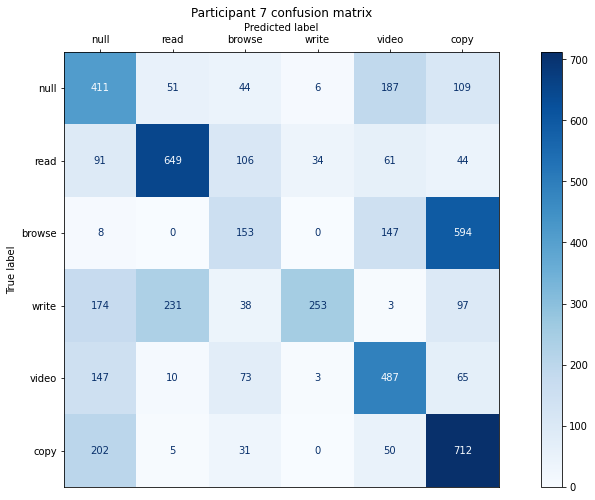


Starting testing participant 8

Training data shape: (38289, 625, 4)   labels shape: (38289, 6)
Testing data shape:  (5805, 625, 4)    labels shape: (5805, 6)

Epoch 1/16
1915/1915 [==============================] - 23s 11ms/step - loss: 1.5288 - accuracy: 0.3726 - val_loss: 1.7012 - val_accuracy: 0.2351
Epoch 2/16
1915/1915 [==============================] - 21s 11ms/step - loss: 1.3291 - accuracy: 0.4719 - val_loss: 1.7528 - val_accuracy: 0.2319
Epoch 3/16
1915/1915 [==============================] - 21s 11ms/step - loss: 1.2408 - accuracy: 0.5134 - val_loss: 1.9475 - val_accuracy: 0.2314
Epoch 4/16
1915/1915 [==============================] - 21s 11ms/step - loss: 1.1723 - accuracy: 0.5473 - val_loss: 1.9961 - val_accuracy: 0.2705
Epoch 5/16
1915/1915 [==============================] - 21s 11ms/step - loss: 1.1200 - accuracy: 0.5742 - val_loss: 1.7921 - val_accuracy: 0.2651
Epoch 6/16
1915/1915 [==============================] - 21s 11ms/step - loss: 1.0864 - accuracy: 0.5869 - val

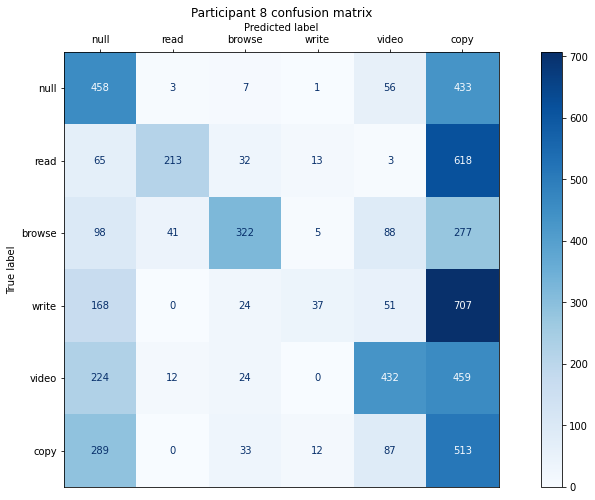

In [ ]:
# Testing the CNN

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import PredefinedSplit

from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Input, LayerNormalization, BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

def compile_model(input_shape = (625, 4), output_nodes = 6, optimizer = 'adam', cnn_activation = 'tanh', dense_activation = 'relu', dropout_rate = 0.2):
  model = Sequential()

  model.add(Input(shape = input_shape))
  model.add(LayerNormalization(axis=1)) # This normalizes across each feature (not each sample). This layer single-handedly raises both accs by 20%

  model.add(Conv1D(4, 3, padding="same", activation=cnn_activation))
  model.add(BatchNormalization())

  model.add(Conv1D(8, 5, padding="same", activation=cnn_activation))
  model.add(BatchNormalization())

  model.add(Conv1D(16, 7, padding="same", activation=cnn_activation))
  #model.add(Conv1D(128, 11, padding="same", activation='tanh'))
  model.add(BatchNormalization())

  model.add(GlobalAveragePooling1D())

  #model.add(Dense(256, activation='relu'))
  #model.add(Dense(128, activation='relu'))
  #model.add(Dropout(0.5))
  #model.add(Dense(64, activation='relu'))
  #model.add(Dropout(0.4))
  model.add(Dense(32, activation=dense_activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(16, activation=dense_activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(output_nodes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model



# For each test, one participant is the test participant (not included in the training set).

results = {}    # Save the histories of each testing participant
first_iteration = True    # For printing the model summary only once

for testing_participant in range(1, 9):
  training_participants = list(range(1, 9))
  training_participants.remove(testing_participant)
  
  X_train, y_train = concat_datasets(datasets_dict, training_participants)
  X_test, y_test = concat_datasets(datasets_dict, [testing_participant])

  X_train, y_train = shuffle(X_train, y_train)
  X_test, y_test = shuffle(X_test, y_test)

  print(f"\nStarting testing participant {testing_participant}\n")

  print(f"Training data shape: {X_train.shape}   labels shape: {y_train.shape}")
  print(f"Testing data shape:  {X_test.shape}    labels shape: {y_test.shape}\n")

  # Makes a fresh model for every person
  model = compile_model(input_shape = X_train.shape[1:], output_nodes = y_train.shape[1])

  if first_iteration:
    model.summary()
    first_iteration = False

  # Run Grid Search or fit the model (uncomment one line or the other)
  #grid_search(X_train, y_train, X_test, y_test)
  results[testing_participant] = model.fit(X_train, y_train, batch_size = 20, epochs=16, validation_data = (X_test, y_test)) # saves the history of the training session

  # Plot the confusion matrix (comment this segment out if running Grid Search)
  true_labels = [np.argmax(el) for el in y_test]
  predictions = [np.argmax(el) for el in model.predict(X_test)]
  plot_conf_matrix(true_labels, predictions)